<a href="https://colab.research.google.com/github/Superkid0714/ML-DL_practice/blob/main/The_Oxford_IIIT_Pet_Dataset_(%EC%97%B0%EC%8A%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 배열
import numpy as np

# 데이터 분석
import pandas as pd

In [2]:
# Pandas option 정의
pd.set_option( 'display.max_columns', 20 )
pd.set_option( 'display.max_colwidth', 20 )
pd.set_option( 'display.unicode.east_asian_width', True )

In [3]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Jupyter note상에 그래프 결과 포함 매직 명령
%matplotlib inline

# Matplotlib 기본 글꼴 정의
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
import sys

# 노트북이 코랩에서 실행 중인지 체크합니다.
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections

    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

#     # 나눔바른고딕 폰트로 설정합니다.
    import matplotlib.pyplot as plt
    plt.rc('font', family='NanumBarunGothic')

#     # 마이너스 기호 표시 오류 수정
    import matplotlib
    matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 123586 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [6]:
# 경고 문제 출력 제한
import warnings

warnings.filterwarnings( 'ignore' )

In [7]:
# Tensorflow
import tensorflow as tf

tf.__version__

'2.15.0'

In [8]:
# Tensorflow Sequential model
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Rescaling

from tensorflow.keras import optimizers, regularizers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras.utils import plot_model

In [9]:
# 데이터 분리를 위한 함수
from sklearn.model_selection import train_test_split

In [10]:
def disp_training( history ):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range( 1, len( accuracy ) + 1 )

    plt.title( '훈련 및 검증 정확도' )
    plt.plot( epochs, history.history[ 'accuracy' ], label = 'accuracy' )
    plt.plot( epochs, history.history[ 'val_accuracy' ], label = 'val_accuracy' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Epochs' )

    plt.figure()
    plt.title( '훈련 및 검증 오차' )

    plt.plot( epochs, history.history[ 'loss' ], label = 'loss' )
    plt.plot( epochs, history.history[ 'val_loss' ], label = 'val_loss' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Epochs' )

    plt.show()

In [11]:
def disp_loss( history ):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range( 1, len( loss ) + 1 )

    plt.title( '훈련 및 검증 오차' )

    plt.plot( epochs, history.history[ 'loss' ], label = 'loss' )
    plt.plot( epochs, history.history[ 'val_loss' ], label = 'val_loss' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Epochs' )

    plt.show()

## 이미지 분할

### 데이터 준비

In [12]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-07-22 14:20:27--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-07-22 14:20:27--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-07-22 14:20:27--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

### 입력 파일 경로와 분할 마스크 경로에 대한 리스트 구성

In [13]:
import os

input_dir = 'images/'
target_dir = 'annotations/trimaps/'

# 입력 데이터
input_img_paths = sorted(
    [ os.path.join( input_dir, fname ) for fname in os.listdir( input_dir ) if fname.endswith( '.jpg') ]
)
# 정답 데이터
target_paths = sorted(
    [ os.path.join( target_dir, fname ) for fname in os.listdir( target_dir )
      if fname.endswith( '.png') and not fname.startswith( '.' ) ]
)

In [14]:
print(f'input image length:{len(input_img_paths)}')
print(f'target length:{len(target_paths)}')

input image length:7390
target length:7390


In [15]:
input_img_paths[0]

'images/Abyssinian_1.jpg'

In [16]:
target_paths[0]

'annotations/trimaps/Abyssinian_1.png'

### 입력 이미지와 분할 이미지 확인

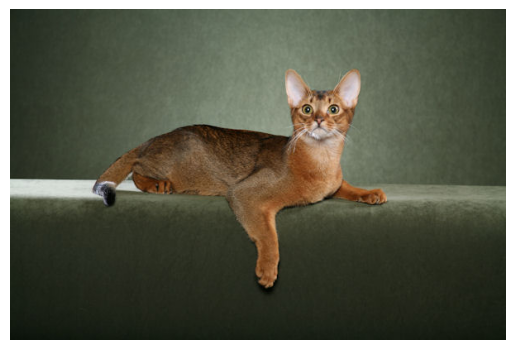

In [17]:
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[0]))

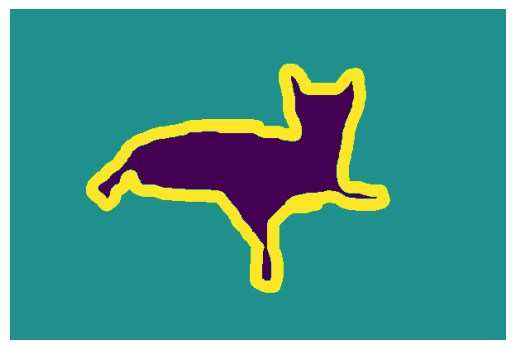

In [18]:
def display_target(target_array):
  normalized_array = (target_array.astype('uint8')-1) * 127
  plt.axis('off')
  plt.imshow(normalized_array[:,:,0])

img = img_to_array(load_img(target_paths[0], color_mode = 'grayscale') )
display_target(img)

### 훈련/ 검증셋 분할

* 입력 / 타킷 데이터 Numpy 배열로 변환

In [19]:
import random

img_size = (200,200)  # image 크기
num_imgs = len(input_img_paths) # image 개수

# image 임의로 섞기
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

In [20]:
# 입력/검증 이미지 분할을 위한 image load
def path_to_input_image( path ):
    return img_to_array( load_img( path, target_size = img_size ) )

def path_to_target( path ):
    img = img_to_array(
        load_img( path, target_size = img_size, color_mode = 'grayscale' )
    )
    img = img.astype( 'uint8' ) - 1

    return img

In [21]:
# 입력/정답 이미지 load
input_imgs = np.zeros( ( num_imgs, ) + img_size + ( 3, ), dtype = 'float32' )
targets = np.zeros( ( num_imgs, ) + img_size + ( 1, ), dtype = 'uint8' )
for i in range( num_imgs ):
    input_imgs[ i ] = path_to_input_image( input_img_paths[ i ] )
    targets[ i ] = path_to_target( target_paths[ i ] )

In [22]:
# 입력/정답 이미지 분할
num_val_samples = 1000

train_input_img = input_imgs[:-num_val_samples]
train_target = targets[: -num_val_samples]

val_input_img = input_imgs[-num_val_samples:]
val_target = targets[-num_val_samples:]

In [23]:
train_input_img.shape

(6390, 200, 200, 3)

In [24]:
train_target.shape

(6390, 200, 200, 1)

In [25]:
val_input_img.shape

(1000, 200, 200, 3)

In [26]:
val_target.shape

(1000, 200, 200, 1)

### 이미지 분할 CNN 모델링

In [27]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose

In [28]:
def build_model( img_size, num_classes ):
    inputs = Input( shape = img_size + ( 3, ) )
    x = Rescaling( 1. / 255 )( inputs )

    # Image downsampling
    x = Conv2D( 64, 3, strides = 2, activation = 'relu', padding = 'same' )( x )
    x = Conv2D( 64, 3, activation = 'relu', padding = 'same' )( x )
    x = Conv2D( 128, 3, strides = 2, activation = 'relu', padding = 'same' )( x )
    x = Conv2D( 128, 3, activation = 'relu', padding = 'same' )( x )
    x = Conv2D( 256, 3, strides = 2, activation = 'relu', padding = 'same' )( x )
    x = Conv2D( 256, 3, activation = 'relu', padding = 'same' )( x )

    # Image Upsampling
    x = Conv2DTranspose( 256, 3, activation = 'relu', padding = 'same' )( x )
    x = Conv2DTranspose( 256, 3, strides = 2, activation = 'relu', padding = 'same' )( x )
    x = Conv2DTranspose( 128, 3, activation = 'relu', padding = 'same' )( x )
    x = Conv2DTranspose( 128, 3, strides = 2, activation = 'relu', padding = 'same' )( x )
    x = Conv2DTranspose( 64, 3, activation = 'relu', padding = 'same' )( x )
    x = Conv2DTranspose( 64, 3, strides = 2, activation = 'relu', padding = 'same' )( x )

    outputs = Conv2D( num_classes, 3, activation = 'softmax', padding = 'same' )( x )

    model = Model( inputs = inputs, outputs = outputs )

    return model

In [29]:
model = build_model( img_size = img_size, num_classes = 3 )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

### 이미지 분할 CNN 모델 컴파일 및 훈련

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

rmsprop = optimizers.RMSprop()
model.compile(optimizer =rmsprop, loss='sparse_categorical_crossentropy')

callbacks = [ ModelCheckpoint('img_segmentaion.h5', save_best_only = True)]

history = model.fit(train_input_img, train_target, epochs =50, batch_size =64,
                    validation_data= (val_input_img,val_target),
                    callbacks =callbacks)

Epoch 1/50
100/100 [==============================] - 106s 809ms/step - loss: 0.9466 - val_loss: 0.9050
Epoch 2/50
100/100 [==============================] - 59s 590ms/step - loss: 0.8841 - val_loss: 0.8520
Epoch 3/50
100/100 [==============================] - 60s 600ms/step - loss: 0.8383 - val_loss: 2.1592
Epoch 4/50
100/100 [==============================] - 61s 608ms/step - loss: 0.8155 - val_loss: 0.8941
Epoch 5/50
100/100 [==============================] - 61s 613ms/step - loss: 0.7722 - val_loss: 0.7280
Epoch 6/50
100/100 [==============================] - 61s 611ms/step - loss: 0.7629 - val_loss: 0.7342
Epoch 7/50
100/100 [==============================] - 61s 613ms/step - loss: 0.7313 - val_loss: 0.7559
Epoch 8/50
100/100 [==============================] - 62s 616ms/step - loss: 0.7175 - val_loss: 0.7110
Epoch 9/50
100/100 [==============================] - 63s 634ms/step - loss: 0.6868 - val_loss: 0.6742
Epoch 10/50
100/100 [==============================] - 61s 614ms/step - 

In [33]:
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.models import load_model

model = load_model( 'img_segmentaion.h5' )

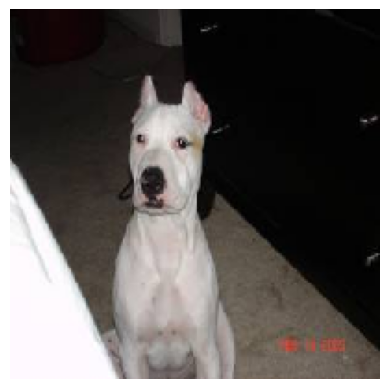

In [34]:
i = 4
test_image = val_input_img[ i ]
plt.axis( 'off' )
plt.imshow( array_to_img( test_image ) )

1/1 [==============================] - 2s 2s/step


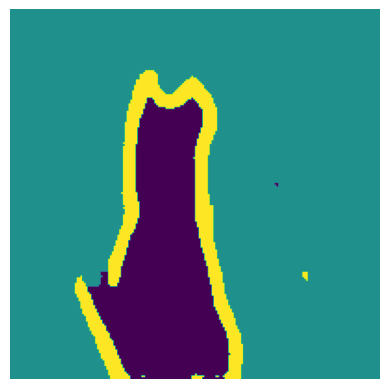

In [35]:
mask = model.predict( np.expand_dims( test_image, 0 ) )[ 0 ]

def display_mask( pred ):
    mask = np.argmax( pred, axis = -1 )
    mask *= 127
    plt.axis( 'off' )
    plt.imshow( mask )

display_mask( mask )